In [ ]:
from fastf1 import api
import pandas as pd
from matplotlib import pyplot as plt
from dfply import *
from datetime import datetime
from datetime import timedelta
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#note: you should put in a new folder to store cached data, github doesn't push empty folders so you have to do it manually
fastf1.Cache.enable_cache('FastF1Cache')

# Data Scraping

In [28]:
def QualiScrape(grandPrix, raceDate, qualiDate):
    """
    Input: grandPrix, Grand Prix's Race Date, Date of Qualifying
    Returns: data frame with each driver matched to best qualifying time, along with tire and weather conditions
    """
    #Build path to scrape data from
    Quali = fastf1.api.make_path(grandPrix, raceDate, 'Qualifying', qualiDate)
    
    #Scraping timing data, timing app data (for info on tire compund), and weather data
    QualiTiming = fastf1.api.timing_data(Quali)[0]
    QualiTimingApp = fastf1.api.timing_app_data(Quali)
    QualiWeatherDict = fastf1.api.weather_data(Quali)
    QualiWeatherData = pd.DataFrame.from_dict(QualiWeatherDict)
    
    #Remove entries with no laptimes, and round session time to nearest minute (for merging purposes)
    QualiTiming = QualiTiming[QualiTiming.LapTime.notnull()]
    QualiTimingApp >>= mutate(Time = X.Time.round('60s')) >> arrange(X.Driver, X.Time)
    QualiTimingApp = QualiTimingApp.reset_index()
    
    #In timing app dataframe, tire compound is only noted when new set is put on
    #Since dataframe is organized by driver and then time, we can replace empty entries with the previous tire compound
    #Also, dataframe sometime doubles on driver-time combo, so removing the unnecessary ones
    for index in range(len(QualiTimingApp)):
        if not QualiTimingApp.loc[index,"Compound"]:
            QualiTimingApp.loc[index, "Compound"] = QualiTimingApp.loc[index-1, "Compound"]
        if not QualiTimingApp.loc[index,"New"]:
            QualiTimingApp.loc[index,"New"] = False
        if index == 0:
            continue
        if QualiTimingApp.loc[index,"Time"] == QualiTimingApp.loc[index-1,"Time"]:
            if not QualiTimingApp.loc[index,"LapTime"]:
                QualiTimingApp.loc[index,"Driver"] = np.nan
            else: 
                QualiTimingApp.loc[index-1,"Driver"] = np.nan                
    QualiTimingApp = QualiTimingApp[QualiTimingApp.Driver.notnull()]
    
    #Selecting relevant rows
    QualiTimingApp >>= select(X.Stint, X.Driver, X.TotalLaps, X.Compound, X.New, X.Time)
    QualiTiming = QualiTiming >> mutate(Time = X.Time.round('60s')) >> arrange(X.Driver, X.Time) >> \
              drop(contains("Session"), X.PitOutTime, X.PitInTime)

    QualiCompiledTiming = pd.merge(QualiTiming,QualiTimingApp, on=['Time', 'Driver'])

    QualiWeatherData >>= mutate(Time = X.Time.round('60s'))
    QualiCompiledTiming = pd.merge(QualiCompiledTiming, QualiWeatherData, on=['Time'])
    QualiCompiledTiming >>= arrange(X.Driver, X.Time)
    QualiCompiledTiming = QualiCompiledTiming.reset_index()
    
    #Creating List of all drivers, then finding the best lap time for them
    driverList = QualiCompiledTiming.Driver.unique()
    QualiTimes = {}
    for drv in driverList:
        QualiTimes[drv] = [drv, QualiTiming[QualiTiming.Driver == drv].LapTime.min()]
    QualiDF = pd.DataFrame.from_dict(QualiTimes, orient = 'index', columns = ['Driver','LapTime'])
    QualiDF = QualiDF.reset_index()
    QualiDF >>= select(X.Driver, X.LapTime)
    
    #Merge weather and tire data with appropriate laptime data
    QualiDF = pd.merge(QualiDF, QualiCompiledTiming, on = ["LapTime", "Driver"])
    
    #Removing variables regarded as unnecessary, adding Qualifying prefix to Data so merging stays clean
    #Note: Qualifying and Practice are merged by driver, so QualifyingDriver is renamed back to driver
    QualiDF >>= drop(X.Time, X.NumberOfLaps, X.NumberOfPitStops, X.IsPersonalBest, X.Stint, X.TotalLaps, X.New, X.WindDirection)
    QualiDF = QualiDF.add_prefix('Qualifying') >> rename(Driver = X.QualifyingDriver)
    QualiDF >>= drop(X.Qualifyingindex)
    
    return QualiDF

def practiceScrape(grandPrix, raceDate, pracNum, pracDate):
    """
    Input: Grand Prix, Grand Prix Date, Which Practice, Which Date
    Output: Dataframe with each driver's timed lap matched with tire compound and weather conditions
    """
    #Make Path to scrape practice data
    FP = fastf1.api.make_path(grandPrix, raceDate, f'Practice {pracNum}', pracDate)
    
    #Scraping timing data, timing app data (for info on tire compund), and weather data
    FPTiming = fastf1.api.timing_data(FP)[0]
    FPTimingApp = fastf1.api.timing_app_data(FP)
    FPWeatherDict = fastf1.api.weather_data(FP)
    FPWeatherData = pd.DataFrame.from_dict(FPWeatherDict)
    
    #Remove entries with no laptimes, and round session time to nearest minute (for merging purposes)
    FPTiming = FPTiming[FPTiming.LapTime.notnull()]
    FPTimingApp >>= mutate(Time = X.Time.round('60s')) >> arrange(X.Driver, X.Time)
    FPTimingApp = FPTimingApp.reset_index()
    
    #In timing app dataframe, tire compound is only noted when new set is put on
    #Since dataframe is organized by driver and then time, we can replace empty entries with the previous tire compound
    #Also, dataframe sometime doubles on driver-time combo, so removing the unnecessary ones
    for index in range(len(FPTimingApp)):
        if not FPTimingApp.loc[index,"Compound"]:
            FPTimingApp.loc[index, "Compound"] = FPTimingApp.loc[index-1, "Compound"]
        if not FPTimingApp.loc[index,"New"]:
            FPTimingApp.loc[index,"New"] = False
        if index == 0:
            continue
        if FPTimingApp.loc[index,"Time"] == FPTimingApp.loc[index-1,"Time"]:
            if not FPTimingApp.loc[index,"LapTime"]:
                FPTimingApp.loc[index,"Driver"] = np.nan
            else: 
                FPTimingApp.loc[index-1,"Driver"] = np.nan                
    FPTimingApp = FPTimingApp[FPTimingApp.Driver.notnull()]
    
    #Selecting relevant rows, and rounding FPtiming session time to nearest minute
    FPTimingApp >>= select(X.Stint, X.Driver, X.TotalLaps, X.Compound, X.New, X.Time)
    FPTiming = FPTiming >> mutate(Time = X.Time.round('60s')) >> arrange(X.Driver, X.Time) >> \
              drop(contains("Session"), X.PitOutTime, X.PitInTime)
    
    #Merge Dataframes, keyed by time and driver, then dropping irrelevant columns
    FPCompiledTiming = pd.merge(FPTiming,FPTimingApp, on=['Time', 'Driver'])
    FPWeatherData >>= mutate(Time = X.Time.round('60s'))
    FPCompiledTiming = pd.merge(FPCompiledTiming, FPWeatherData, on=['Time'])
    FPCompiledTiming >>= arrange(X.Driver, X.Time) >> mutate(Practice = pracNum) >> drop(X.WindDirection, X.Stint, X.TotalLaps)
    FPCompiledTiming = FPCompiledTiming.reset_index()
    return FPCompiledTiming

In [29]:
def weekendCompiler(grandPrix, raceDate, sprint = False):
    """
    Input: Grand Prix with appropriate race date, and whether grand prix was a sprint weekend
    Output: Dataframe with all timed practice laps, merged with info about best qualifying lap
    """
    #Creating relevant dates for session calling purposes
    raceDate = datetime.strptime(raceDate, "%Y-%m-%d")
    friDate = str(raceDate - timedelta(days = 2))[:10]
    satDate = str(raceDate - timedelta(days = 1))[:10]
    raceDate = str(raceDate)[:10]
    
    #Collecting Practice Data
    #Note: On sprint weekends only one practice is done before qualifying, so FP1 is the only relevant data
    FP1CompiledTiming = practiceScrape(grandPrix, raceDate, 1, friDate)
    if not sprint:
        FP2CompiledTiming = practiceScrape(grandPrix, raceDate, 2, friDate)
        FP3CompiledTiming = practiceScrape(grandPrix, raceDate, 3, satDate)
    
    #Collecting Quali Data:
    #Note: On sprint weekends, qualifying is done on Friday, as opposed to usual Saturdays
    if not sprint:
        QualiDF = QualiScrape(grandPrix, raceDate, satDate)
    else:
        QualiDF = QualiScrape(grandPrix, raceDate, friDate)
    
    #Concatenating Practice Dataframes
    if not sprint:
        frames = [FP1CompiledTiming, FP2CompiledTiming, FP3CompiledTiming]
        practiceCompiled = pd.concat(frames)
    else:
        practiceCompiled = FP1CompiledTiming
    
    #Merging Quali Data with compiled Practice data, such that each laptime has the appropriate quali data
    practiceCompiled = practiceCompiled.reset_index()
    practiceCompiled >>= drop(X.level_0)
    practiceCompiled = pd.merge(practiceCompiled, QualiDF, on=['Driver']) >> mutate(Weekend = grandPrix)
    
    return practiceCompiled

In [30]:
raceCalendar = {1:["Bahrain Grand Prix", "2022-03-20"], 2:["Saudi Arabian Grand Prix", "2022-03-27"], 3:["Australian Grand Prix", "2022-04-10"],\
                4:["Emilia Romagna Grand Prix", "2022-04-24"], 5:["Miami Grand Prix", "2022-05-08"], 6:["Spanish Grand Prix", "2022-05-22"], \
                7:["Monaco Grand Prix", "2022-05-29"], 8:["Azerbaijan Grand Prix", "2022-06-12"], 9:["Canadian Grand Prix",  "2022-06-19"], \
                10:["British Grand Prix", "2022-07-03"], 11:["Austrian Grand Prix", "2022-07-10"], 12:["French Grand Prix", "2022-07-24"], \
                13:["Hungarian Grand Prix", "2022-07-31"], 14:["Belgian Grand Prix", "2022-08-28"], 15:["Dutch Grand Prix", "2022-09-04"], \
                16:["Italian Grand Prix", "2022-09-11"], 17:["Singapore Grand Prix", "2022-10-02"], 18:["Japanese Grand Prix", "2022-10-09"], \
                19:["United States Grand Prix", "2022-10-23"], 20:["Mexico City Grand Prix", "2022-10-30"], 21:["São Paulo Grand Prix", "2022-11-13"]}
dfList = []
for key in raceCalendar:
    
    print(f"Collecting Data for {raceCalendar[key][0]}")
    #Imola, Austria, and Brazil are sprint weekends, so they have a special case where sprint = true
    if key not in [4,11,21]:
        dfList.append(weekendCompiler(raceCalendar[key][0], raceCalendar[key][1]))
    else:
        dfList.append(weekendCompiler(raceCalendar[key][0], raceCalendar[key][1], sprint = True))

masterList = pd.concat(dfList)
masterList >>= drop(X.Time)

api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
api            INFO 	Using cached data for weather_data


Clean Data For Neural Network

In [5]:

nn_copy = masterList.copy()
nn_copy = pd.get_dummies(nn_copy, columns = ['Weekend', 'Driver', 'Compound', 'QualifyingCompound'])

#Convert to Seconds 
nn_copy['LapTime'] = (pd.to_numeric(nn_copy['LapTime'], errors = 'coerce')) / 1000000000
nn_copy['Sector1Time'] = (pd.to_numeric(nn_copy['Sector1Time'], errors = 'coerce')) / 1000000000
nn_copy['Sector2Time'] = (pd.to_numeric(nn_copy['Sector2Time'], errors = 'coerce')) / 1000000000
nn_copy['Sector3Time'] = (pd.to_numeric(nn_copy['Sector3Time'], errors = 'coerce')) / 1000000000
nn_copy['QualifyingLapTime'] = (pd.to_numeric(nn_copy['QualifyingLapTime'], errors = 'coerce')) / 1000000000

#Adjust Boolean Data
nn_copy['New'] = pd.to_numeric(nn_copy['New'], errors = 'coerce')

#Remove Bad Data
del nn_copy['index']
del nn_copy['QualifyingSector1Time']
del nn_copy['QualifyingSector2Time']
del nn_copy['QualifyingSector3Time']
del nn_copy['QualifyingSpeedI1']
del nn_copy['QualifyingSpeedI2']
del nn_copy['QualifyingSpeedFL']
del nn_copy['QualifyingSpeedST']
nn_copy = nn_copy.dropna()

In [6]:
#Set training variables(X) and prediction variables (Y)
x = nn_copy >> drop(X.QualifyingLapTime)
             
y = nn_copy['QualifyingLapTime']

#Normalize Training Data

x_scaler = preprocessing.StandardScaler().fit(x)
x_norm = x_scaler.transform(x)

#Split Data Into Test and Training Sets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2)

x_train = np.asarray(x_train).astype(float)
y_train = np.asarray(y_train).astype(float)
x_test = np.asarray(x_test).astype(float)
y_test = np.asarray(y_test).astype(float)

#Split Test Data Into Validation and Test Sets
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size = 0.5)

"Standard" Neural Network Following General Guidelines 

In [ ]:
#One layer is generally enough for simple problems like this (As opposed to something like digit recognition)
#Hidden layer size is generally between the input size (number of x variables) and the output size (number of y variables)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation = 'relu'),
])

#Adam is the recommended default optimizer
#Mean squared error loss function as seen in class
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
#Start Batch Size Small (Powers of 2 for efficient GPU usage)
#Epochs rule of thumb is to start with triple the amount of columns
#Verbose determines how it prints the training progress
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)

#Evaluate Model 
model.evaluate(x_validation, y_validation, verbose = 2)

What If We Adjust The Network Architecture?

In [ ]:
#This one is good
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)                                                                   

In [ ]:
#This one is bad
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)

In [ ]:
#This one is bad
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)   

In [ ]:
#This one is good
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)   

In [ ]:
#This one is bad
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)   

In [ ]:
#This one is best
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)   

In [ ]:
#Evaluate best model with test data
model.evaluate(x_test, y_test)

What if we change the activation function? (They are all worse than relu)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'linear'),
    tf.keras.layers.Dense(16, activation = 'linear'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)  

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'sigmoid'),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)  

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(16, activation = 'tanh'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 32, epochs = 100, verbose = 2)      
model.evaluate(x_validation, y_validation, verbose = 2)  

What if we adjust batch size?

In [ ]:
#This one is bad
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 64, epochs = 100, verbose = 0)
model.evaluate(x_validation, y_validation, verbose = 2)

In [ ]:
#This one is superior
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 8, epochs = 100, verbose = 0)
model.evaluate(x_validation, y_validation, verbose = 2)

In [ ]:
#This one is even more superior (Not going smaller because run time is very long)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.MSE, metrics = [tf.keras.metrics.MeanSquaredError(),
                                                                         tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size = 4, epochs = 100, verbose = 0)
model.evaluate(x_validation, y_validation, verbose = 2)

What if we add more epochs?

In [31]:
#Much better but takes a long time to train and could cause overfitting (Best model with all the data)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
])
model.compile(optimizer='adam', loss=tf.keras.losses.MSE, metrics=[tf.keras.metrics.MeanSquaredError(),
                                                                   tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, batch_size=32, epochs=1000, verbose=2)
model.evaluate(x_validation, y_validation, verbose=2)

Epoch 1/1000
347/347 - 1s - loss: 5923.2236 - mean_squared_error: 5923.2236 - mean_absolute_error: 75.5194 - 1s/epoch - 4ms/step
Epoch 2/1000
347/347 - 1s - loss: 1052.0355 - mean_squared_error: 1052.0355 - mean_absolute_error: 27.6431 - 806ms/epoch - 2ms/step
Epoch 3/1000
347/347 - 1s - loss: 103.4032 - mean_squared_error: 103.4032 - mean_absolute_error: 7.8529 - 800ms/epoch - 2ms/step
Epoch 4/1000
347/347 - 1s - loss: 54.3754 - mean_squared_error: 54.3754 - mean_absolute_error: 5.4817 - 906ms/epoch - 3ms/step
Epoch 5/1000
347/347 - 1s - loss: 39.6448 - mean_squared_error: 39.6448 - mean_absolute_error: 4.6462 - 842ms/epoch - 2ms/step
Epoch 6/1000
347/347 - 1s - loss: 30.5396 - mean_squared_error: 30.5396 - mean_absolute_error: 4.0673 - 867ms/epoch - 2ms/step
Epoch 7/1000
347/347 - 1s - loss: 24.2622 - mean_squared_error: 24.2622 - mean_absolute_error: 3.6081 - 826ms/epoch - 2ms/step
Epoch 8/1000
347/347 - 1s - loss: 19.7891 - mean_squared_error: 19.7891 - mean_absolute_error: 3.2251 

Epoch 66/1000
347/347 - 1s - loss: 0.6496 - mean_squared_error: 0.6496 - mean_absolute_error: 0.2145 - 849ms/epoch - 2ms/step
Epoch 67/1000
347/347 - 1s - loss: 0.6417 - mean_squared_error: 0.6417 - mean_absolute_error: 0.2077 - 793ms/epoch - 2ms/step
Epoch 68/1000
347/347 - 1s - loss: 0.6400 - mean_squared_error: 0.6400 - mean_absolute_error: 0.2089 - 979ms/epoch - 3ms/step
Epoch 69/1000
347/347 - 1s - loss: 0.6307 - mean_squared_error: 0.6307 - mean_absolute_error: 0.1972 - 858ms/epoch - 2ms/step
Epoch 70/1000
347/347 - 1s - loss: 0.6266 - mean_squared_error: 0.6266 - mean_absolute_error: 0.1927 - 808ms/epoch - 2ms/step
Epoch 71/1000
347/347 - 1s - loss: 0.6231 - mean_squared_error: 0.6231 - mean_absolute_error: 0.1890 - 777ms/epoch - 2ms/step
Epoch 72/1000
347/347 - 1s - loss: 0.6217 - mean_squared_error: 0.6217 - mean_absolute_error: 0.1901 - 829ms/epoch - 2ms/step
Epoch 73/1000
347/347 - 1s - loss: 0.6180 - mean_squared_error: 0.6180 - mean_absolute_error: 0.1824 - 781ms/epoch - 2

KeyboardInterrupt: 

In [ ]:
Final Test

In [23]:
model.evaluate(x_test, y_test, verbose=2)

44/44 - 0s - loss: 0.9996 - mean_squared_error: 0.9996 - mean_absolute_error: 0.5657 - 229ms/epoch - 5ms/step


[0.9995534420013428, 0.9995534420013428, 0.5657118558883667]

In [15]:
%matplotlib inline
class PlotData():
    """
    A module for storing plot data in a more portable, reusable form
    Stores x and y data and metadata (title, labels, etc.)
    Parameters: 2 arrays of x and y datasets (to allow multiple relations per plot), 
                plot type as a string, title, axis labels, and grid boolean
    """
    def __init__(self, xdata, ydata, ptype='plot', title='Figure', xlabel='x axis', ylabel='y axis', grid=True):
        # Throws error if xdata and ydata length do not match
        if not len(xdata) == len(ydata):
            raise Exception('Data mismatch error: must have the same number of corresponding x and y fields')
            
        # Throws error if x and y subdata length do not match
        for i in range(len(xdata)):
            if not len(xdata[i]) == len(ydata[i]):
                raise Exception(f'Data mismatch error: {i}th set of x and y data have unequal length')
            
        self.xdata = xdata
        self.ydata = ydata
        self.ptype = ptype
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.grid = grid
        
        
    def plot(self, style='b--'):
        """
        May not be showing it but it do be plotting the data
        Input: Optional style
        """
        # Plots based on type
        if self.ptype == 'plot':
            for i in range(len(self.xdata)):
                plt.plot(self.xdata[i], self.ydata[i], style)
                
        elif self.ptype == 'scatter':
            for i in range(len(self.xdata)):
                plt.scatter(self.xdata[i], self.ydata[i], style)
            
        elif self.ptype == 'bar':
            for i in range(len(self.xdata)):
                plt.bar(self.xdata[i], self.ydata[i])
            
        else:
            print(f'{self.title} has invalid plot type')
                
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        if self.grid:
            plt.grid()
            
            
    def addData(x, y):
        """
        Clears the figure and adds a new x-y relation to the data
        Input: x and y data to add
        Output: It adds the data wow
        """
        plt.clf()
        self.xdata.append(x)
        self.ydata.append(y)
            
        

In [17]:
class Plotter():
    """
    Takes plot data and auto-generates subplots
    Parameters: a list of PlotData objects
    """
    
    def __init__(self, plots, subdim=None):
        self.plots = plots
        self.subdim = subdim
        self.arrange(self.subdim)
        self.figsize = (5*self.subdim[1], 5*self.subdim[0])
        
        
        
    def addPlot(plot, loc=-1, subdim=None):
        """
        Adds a new subplot and rearranges the figure
        Input: the PlotData to add, the location to display it, and a custom aspect ratio if desired
        Output:  It does it
        """
        self.plots.insert(loc, plot)
        if not subdim == None:
            self.subdim = subdim
        else:
            arrange()
    
    
    def addData(x, y, loc):
        """
        Adds data to a subplot
        Input: x and y data to add, and which subplot to add to
        Output: It also does it
        """
        self.plots[loc].addData(x, y)
    
    
    def arrange(self, subdim=None):
        """
        Helper function to redistrubte subplots to maximize squareness or fulfill user-set dimensions
        Input: Optional custom dimensions
        Output: :)
        """
        if not subdim == None:
            # Throw error if there are not enough subplot spaces
            if subdim[0] * subdim[1] < len(self.plots):
                raise Exception('Specified plot dimensions cannot fit specidied subplot data. Try doing math')
            self.subdim = subdim
        else:
            # Find the arrangement closest to square that fills all subplots
            for i in range(int(np.sqrt(len(self.plots))), 0, -1):
                if len(self.plots) % i == 0:
                    self.subdim = (i, len(self.plots) // i)
                    break
        
                
    def plot(self):
        """
        Generates the figure
        """
        plt.figure(figsize=self.figsize)
        for i in range(len(self.plots)):
            plt.subplot(self.subdim[0], self.subdim[1], i + 1)
            self.plots[i].plot()
        plt.tight_layout()
        
        

In [11]:
def genDrivers(weekendDF):
    """
    Generates a dictionary of driver IDs to driver stats
    Input: Dataframe
    Output: Dictionary of driver IDs to driver stat dataframe (which is a subset of the input)
    """
    idList = list(set(weekendDF['Driver'].values))
    return {ID : weekendDF.loc[weekendDF['Driver'] == ID] for ID in idList}

In [18]:
def getAverages(dataframe, race, driverIDs, category):
    """
    Generates a list of average values for a driver stat in a given race
    Input: Dictionary of races to dictionaries of IDs to driver dataframes, the race to 
           select, the driver to select, and the driver stat to average
    Output: The mean value
    """
    
    averages = []
    for ID in driverIDs:
        # If the driver is not present they get 0
        try:
            averages.append(dataframe[race][ID][category].values.mean().item() / 1.0e9)
        except:
            averages.append(0)
    return averages

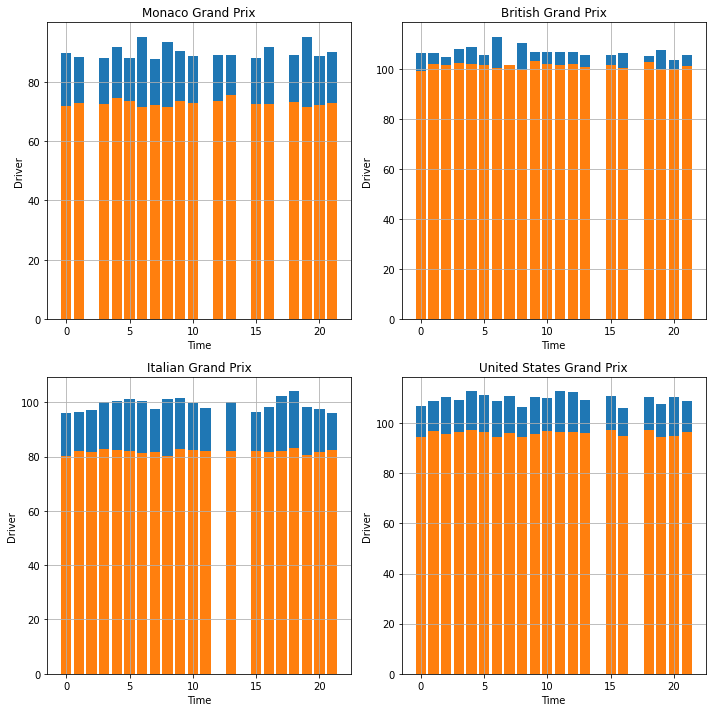

In [21]:
# Trim down to just the data we're interested in
categories = ['Driver', 'LapTime', 'Sector1Time', 'Sector2Time','Sector3Time', 'Compound', 'QualifyingLapTime', 
          'QualifyingSector1Time', 'QualifyingSector2Time','QualifyingSector3Time', 'QualifyingCompound', 'Weekend']
plotDF = masterList[categories].copy()

# Split data into a dictionary by race
raceNames = [race[0] for race in raceCalendar.values()]
raceDFs = {race : plotDF.loc[plotDF["Weekend"] == race] for race in raceNames}

# Split dictionary of races further into to dictionaries of driver IDs to driver data
# Get a specific datafield with raceDrivers['raceName']['driverID']['field'].values
raceDrivers = {name : genDrivers(raceDFs[name]) for name in raceNames}

# Set chosen races and make sorted list of driver IDs
selectedRaces = [raceNames[6], raceNames[9], raceNames[15], raceNames[18]]
#selectedRaces = raceNames
driverIDs = list(set([int(ID) for ID in plotDF['Driver'].values]))
driverIDs.sort()
driverIDs = [str(ID) for ID in driverIDs]

# Collect average practice lap time and average qualifying lap time for each selected race
lapAverages, qualifyingAverages = [], []
for race in selectedRaces:
    lapAverages.append(getAverages(raceDrivers, race, driverIDs, 'LapTime'))
    qualifyingAverages.append(getAverages(raceDrivers, race, driverIDs, 'QualifyingLapTime'))

# Auto-generate plots
xDataSets = [[j for j in range(len(lapAverages[i]))] for i in range(2)]
lapPlotData = [PlotData(xDataSets, [lapAverages[i], qualifyingAverages[i]], 'bar', selectedRaces[i], 'Time', 'Driver') for i in range(len(lapAverages))]
plotter = Plotter(lapPlotData)
plotter.plot()
plt.savefig('plots.png')
    

